# Case Study #1: Medicare Analysis

#### Overview
    - The goal is to use the Medicare datasets to visualize answers to questions such as the market volume of top procedures
    - To do that, we can use procedure codess (HCPCS/CPT) to categorize and understand the data

#### Pre-Requisites:
    - Jupyter notebook via Anaconda (https://www.anaconda.com/)
    - Basic understanding of Python and Pandas
    - Medicare datasets (in the example below, the datasets are under ./input_datasets/, but you can update the file path below accordingly)
    - The Jupyter notebook for analysis has been created in the same location as the input datasets (in the example below, the datasets are under a subfolder, which is still easily accessible via relative path)

## Step 0. Get Raw Input Datasets

Here we will 1) load original datasets, 2) remove unused columns, 3) de-duplicate rows, and 4) join datasets, not necessarily in this order

Assumptions: 
- Claim ID (cur_clm_uniq_id) represents one claim, which may or may not have more than one code (code could be HCPCS/CPT, diagnosis, procedure...)
- There is a one-to-many relationship between patient IDs (bene_mbi_id) and claim IDs (cur_clm_uniq_id), i.e. each claim is unique to one patient, but one patient can have more than one claim

### 0.1 Import required packages

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Turn off the automatic setting that redacts the columns/rows from the dataframe output
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 200)

### 0.2 Load & select columns to be used from raw (original) datasets

### 0.2.1 Load & select columns from Claims Header dataset

In [3]:
# Load Claims Header dataset
parta_claims_header_raw_df = pd.read_csv("input_datasets/parta_claims_header.csv")
parta_claims_header_raw_df.sort_values(by=['cur_clm_uniq_id'])

,cur_clm_uniq_id,prvdr_oscar_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_bill_fac_type_cd,clm_bill_clsfctn_cd,prncpl_dgns_cd,admtg_dgns_cd,clm_mdcr_npmt_rsn_cd,clm_pmt_amt,clm_nch_prmry_pyr_cd,prvdr_fac_fips_st_cd,bene_ptnt_stus_cd,dgns_drg_cd,clm_op_srvc_type_cd,fac_prvdr_npi_num,oprtg_prvdr_npi_num,atndg_prvdr_npi_num,othr_prvdr_npi_num,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,bene_eqtbl_bic_hicn_num,clm_admsn_type_cd,clm_admsn_src_cd,clm_bill_freq_cd,clm_query_cd,dgns_prcdr_icd_ind,clm_mdcr_instnl_tot_chrg_amt,clm_mdcr_ip_pps_cptl_ime_amt,clm_oprtnl_ime_amt,clm_mdcr_ip_pps_dsprprtnt_amt,clm_hipps_uncompd_care_amt,clm_oprtnl_dsprtnt_amt
510,100190,111821,1228,NaN,40,2018-06-10,2018-06-10,7,7,M1611,NaN,NaN,127.79,NaN,11,1,NaN,F,1780608992,NaN,1.972732e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,415.80,NaN,NaN,NaN,NaN,NaN
521,100402,100226,1261,NaN,60,2017-05-27,2017-06-02,1,1,K5733,K5733,NaN,10602.46,NaN,10,6,330.0,NaN,1689611501,NaN,1.285688e+09,NaN,NaN,NaN,NaN,NaN,1.0,1,1,3,0,70795.63,609.13,0.00,13.92,231.15,NaN
525,100464,360051,12978,NaN,40,2017-06-26,2017-06-26,1,3,R079,NaN,NaN,199.45,NaN,36,1,NaN,C,1073688354,NaN,1.982693e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,2709.80,NaN,NaN,NaN,NaN,NaN
536,100698,140276,11789,NaN,40,2017-07-28,2017-07-28,1,3,M545,NaN,NaN,85.25,NaN,14,1,NaN,C,1376521575,NaN,1.912991e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,115.00,NaN,NaN,NaN,NaN,NaN
540,100750,230216,12138,NaN,40,2018-01-13,2018-01-13,1,3,Z0289,NaN,N,0.00,NaN,23,9,NaN,C,1982685384,NaN,1.063442e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,226.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1698691,390145,10007,NaN,40,2016-12-11,2016-12-11,1,3,Z01818,NaN,NaN,43.01,NaN,39,1,NaN,C,1689691214,NaN,1.679505e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,235.00,NaN,NaN,NaN,NaN,NaN
4365,1698722,200021,10985,NaN,40,2018-06-16,2018-06-16,1,3,E782,NaN,NaN,179.09,NaN,20,1,NaN,C,1932164795,NaN,1.548289e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,1939.35,NaN,NaN,NaN,NaN,NaN
4366,1698935,210022,1297,NaN,40,2018-04-06,2018-04-06,1,3,I110,NaN,NaN,400.81,NaN,21,9,NaN,C,1205896446,NaN,1.922016e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,554.00,NaN,NaN,NaN,NaN,NaN
4367,1699005,100057,12194,NaN,40,2016-04-27,2016-04-27,1,3,I348,NaN,NaN,265.19,NaN,10,1,NaN,C,1821019571,NaN,1.437130e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,8423.00,NaN,NaN,NaN,NaN,NaN


#### Data Quality Check #1: If true, the original dataset was unique on claim ID

In [4]:
parta_claims_header_raw_df_count = parta_claims_header_raw_df.shape[0]
parta_claims_header_raw_uniq_clm_id_df = parta_claims_header_raw_df['cur_clm_uniq_id'].drop_duplicates()

parta_claims_header_raw_df_count == parta_claims_header_raw_uniq_clm_id_df.shape[0]

True

In [5]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
parta_claims_header_df = parta_claims_header_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'atndg_prvdr_npi_num', 
    'clm_from_dt', 'prncpl_dgns_cd', 'clm_pmt_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'atndg_prvdr_npi_num': 'npi_id'
    }
)
parta_claims_header_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt
0,1001595,10226,1.366492e+09,2018-02-28,M25551,259.01
1,1004555,10133,1.942275e+09,2018-11-02,Z9861,29.56
2,1011605,10163,1.578546e+09,2018-01-02,C439,45.88
3,1011758,1003,1.952368e+09,2018-06-12,R310,9.40
4,101424,10052,1.336125e+09,2016-04-13,L821,34.18
...,...,...,...,...,...,...
8621,999774,10367,NaN,2017-11-06,R072,374.08
8622,999808,10496,1.740225e+09,2017-07-19,R079,360.89
8623,999878,12160,1.497784e+09,2018-01-18,R5383,90.73
8624,999961,12090,1.083691e+09,2018-03-10,C73,329.44


#### Data Quality Check #2: If true, the filtered dataset did not have any duplicates

In [6]:
parta_claims_header_df_count = parta_claims_header_df.shape[0]

parta_claims_header_raw_df_count == parta_claims_header_df_count

True

#### Data Quality Check #3: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [7]:
parta_claims_header_df.loc[~parta_claims_header_df.prncpl_dgns_cd.notnull()]

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt


### 0.2.2 Load & select columns from Claims Revenue Center dataset

In [8]:
# Load Claims Revenue Center dataset
# Note this dataset has more than one record for each claim ID (cur_clm_uniq_id)
# Also note there are two sets of date columns, 
#  one for claim ID (clm_from/thru_dt) and one for claim line (clm_line_from/thru_dt)
parta_claims_revenue_center_detail_raw_df = pd.read_csv(
    "input_datasets/parta_claims_revenue_center_detail.csv"
)
parta_claims_revenue_center_detail_raw_df.sort_values(by=['cur_clm_uniq_id'])

C:\Users\a4239\AppData\Local\Temp\ipykernel_26356\3270912918.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  parta_claims_revenue_center_detail_raw_df = pd.read_csv(


,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd
318,100073,1,12620,NaN,40,2018-12-02 00:00:00,2018-12-02 00:00:00,403,2018-12-02 00:00:00,77063,NaN,NaN,2018-12-02 00:00:00,2018-12-02 00:00:00,1,24.11,NaN,NaN,NaN,NaN,NaN,00000
383,100184,1,10080,NaN,40,2018-09-06 00:00:00,2018-09-06 00:00:00,1,NaN,NaN,NaN,NaN,2018-09-06 00:00:00,2018-09-06 00:00:00,0,0.00,NaN,NaN,NaN,NaN,NaN,00000
384,100190,1,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,G0467,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,133.74,NaN,NaN,NaN,NaN,NaN,00000
385,100190,2,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,98960,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000
386,100190,3,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,J1100,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,4,0.00,NaN,NaN,NaN,NaN,NaN,00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29896,1699197,2,1177,NaN,40,2016-05-22 00:00:00,2016-05-22 00:00:00,302,2016-05-22 00:00:00,86592,NaN,NaN,2016-05-22 00:00:00,2016-05-22 00:00:00,1,5.43,NaN,NaN,NaN,NaN,NaN,00000
29898,1699212,1,1262,NaN,60,2018-12-24 00:00:00,2018-12-25 00:00:00,730,NaN,NaN,NaN,NaN,2018-12-24 00:00:00,2018-12-25 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,00000
29901,1699236,3,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,370,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,2,0.00,NaN,NaN,NaN,NaN,NaN,00000
29899,1699236,1,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,258,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000


#### Data Quality Check #4: If the resulting dataframe is empty, it means there is no difference between columns 'clm_line_from_dt' and 'clm_from_dt' for all the rows

In [9]:
parta_claims_revenue_center_detail_raw_df.loc[
    ~(parta_claims_revenue_center_detail_raw_df['clm_line_from_dt'] 
      == parta_claims_revenue_center_detail_raw_df['clm_from_dt'])
]

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd


In [10]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Select 'clm_from_dt' as the column for claim dates since we want uniqueness on claim ID, not claim line
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_from_dt',
    'clm_line_hcpcs_cd', 'clm_line_cvrd_pd_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code'
    }
)
parta_claims_revenue_center_detail_df

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.00
1,1001595,10226,2018-02-28 00:00:00,G0283,9.67
7,1001595,10226,2018-02-28 00:00:00,G8978,0.00
8,1001595,10226,2018-02-28 00:00:00,G8979,0.00
10,1001595,10226,2018-02-28 00:00:00,97110,24.97
...,...,...,...,...,...
59414,999961,12090,2018-03-10 00:00:00,A9516,0.00
59415,999961,12090,2018-03-10 00:00:00,G8996,0.00
59416,999976,10768,2016-01-18 00:00:00,80053,11.37
59417,999976,10768,2016-01-18 00:00:00,80061,12.83


#### Data Quality Check #5: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [11]:
parta_claims_revenue_center_detail_df.loc[
    ~parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.0
25,1001595,10226,2018-02-28 00:00:00,NaN,0.0
29,1004555,10133,2018-11-02 00:00:00,NaN,0.0
30,1004904,10106,2018-02-26 00:00:00,NaN,0.0
32,100974,10042,2017-02-20 00:00:00,NaN,0.0
...,...,...,...,...,...
59369,999008,12473,2018-08-04 00:00:00,NaN,0.0
59402,999774,10367,2017-11-06 00:00:00,NaN,0.0
59407,999808,10496,2017-07-19 00:00:00,NaN,0.0
59410,999943,11021,2016-11-20 00:00:00,NaN,0.0


In [12]:
# Data Quality Check #5 failed, so remove rows with no HCPCS codes
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_df.loc[
    parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

In [13]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(
    parta_claims_revenue_center_detail_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_claims_revenue_center_detail_df

C:\Users\a4239\AppData\Local\Temp\ipykernel_26356\2671745514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(


,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
1,1001595,10226,2018-02-28,G0283,9.67
7,1001595,10226,2018-02-28,G8978,0.00
8,1001595,10226,2018-02-28,G8979,0.00
10,1001595,10226,2018-02-28,97110,24.97
18,1001595,10226,2018-02-28,97140,20.33
...,...,...,...,...,...
59413,999961,12090,2018-03-10,78014,400.05
59414,999961,12090,2018-03-10,A9516,0.00
59415,999961,12090,2018-03-10,G8996,0.00
59416,999976,10768,2016-01-18,80053,11.37


#### Mini-Analysis #1: Find whether there are matching claims between Claim Header and Claims Revenue Center datasets

                                                ***

In [14]:
claims_header_unique_claims_df = parta_claims_header_df[[
    'claim_id'
]].drop_duplicates()

claims_header_unique_claims_df['header'] = 1

revenue_center_unique_claims_df = parta_claims_revenue_center_detail_df[[
    'claim_id'
]].drop_duplicates()

revenue_center_unique_claims_df['revenue'] = 1

joined_df1 = pd.merge(
    claims_header_unique_claims_df,
    revenue_center_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df1

,claim_id,header,revenue
0,1001595,1.0,1.0
1,1004555,1.0,1.0
2,1011605,1.0,1.0
3,1011758,1.0,1.0
4,101424,1.0,NaN
...,...,...,...
15721,999074,NaN,1.0
15722,999324,NaN,1.0
15723,999350,NaN,1.0
15724,999514,NaN,1.0


In [15]:
print('# of unique claims in Claims Header dataset: ' 
      + str(claims_header_unique_claims_df.shape[0])
     )
print('# of unique claims in Claims Revenue Center dataset: ' 
      + str(revenue_center_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header dataset: 8626
# of unique claims in Claims Revenue Center dataset: 13406


In [16]:
print('# of unique claims in Claims Header and Claims Revenue Center datasets combined: ' 
      + str(joined_df1.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only Claims Header dataset: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & ~(joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in only Claims Revenue Center dataset: ' 
      + str(joined_df1.loc[~(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in both Claims Header AND Claims Revenue Center datasets: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )

# of unique claims in Claims Header and Claims Revenue Center datasets combined: 15726
From combined list of unique claims - 
# of unique claims in only Claims Header dataset: 2320
# of unique claims in only Claims Revenue Center dataset: 7100
# of unique claims in both Claims Header AND Claims Revenue Center datasets: 6306


Conclusion: There are quite a number of claims available in both datasets, so join them on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.3 Load & select columns from Diagnosis dataset

In [17]:
# Load the Diagnosis dataset
# Note that 'clm_from_dt' has some records with null values, but we need claim dates for all claims
parta_diagnosis_code_raw_df = pd.read_csv("input_datasets/parta_diagnosis_code.csv")
parta_diagnosis_code_raw_df.sort_values(by=['cur_clm_uniq_id', 'clm_val_sqnc_num'])

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_prod_type_cd,clm_val_sqnc_num,clm_dgns_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_poa_ind,dgns_prcdr_icd_ind
244,100190,1228,NaN,40,NaN,1,M1611,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
243,100190,1228,NaN,40,NaN,2,M25572,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
246,100190,1228,NaN,40,NaN,3,M25551,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
245,100190,1228,NaN,40,NaN,4,M5136,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
366,100402,1261,NaN,60,NaN,11,E119,NaN,100256.0,2017-05-28 00:00:00,2017-06-02 00:00:00,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232,1699102,11842,NaN,60,NaN,13,Z8673,NaN,330191.0,2017-01-31 00:00:00,2017-02-03 00:00:00,0,0
16236,1699137,10873,NaN,40,NaN,1,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16235,1699137,10873,NaN,40,NaN,2,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16237,1699155,11689,NaN,40,NaN,3,K219,NaN,NaN,NaN,2018-12-06 00:00:00,NaN,0


In [18]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Use 'clm_thru_dt' as claim date columns since 'clm_from_dt' has some nulls
parta_diagnosis_code_df = parta_diagnosis_code_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_thru_dt', 'clm_dgns_cd'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_thru_dt': 'claim_date'
    }
)
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30 00:00:00,K5289
1,1001595,10226,2018-02-28 00:00:00,M25551
2,1001595,10226,2018-02-28 00:00:00,M79604
3,1001865,10133,2018-09-14 00:00:00,G459
4,1004555,10133,2018-11-02 00:00:00,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18 00:00:00,N390
32048,999943,11021,2016-11-20 00:00:00,M545
32049,999961,12090,2018-03-10 00:00:00,C73
32050,999962,11030,2018-07-17 00:00:00,G8194


#### Data Quality Check #6: If the resulting dataframe is empty, it means all the records have values for 'clm_thru_dt' (if it's not empty it should be removed now since without claim dates it'd be difficult to use)

In [19]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.claim_date.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


#### Data Quality Check #7: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [20]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.clm_dgns_cd.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


In [21]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_diagnosis_code_df['claim_date'] = pd.to_datetime(
    parta_diagnosis_code_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30,K5289
1,1001595,10226,2018-02-28,M25551
2,1001595,10226,2018-02-28,M79604
3,1001865,10133,2018-09-14,G459
4,1004555,10133,2018-11-02,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18,N390
32048,999943,11021,2016-11-20,M545
32049,999961,12090,2018-03-10,C73
32050,999962,11030,2018-07-17,G8194


#### Mini-Analysis #2: Find whether there are matching claims between above two datasets and the Diagnosis dataset

                                                ***

In [22]:
diagnosis_unique_claims_df = parta_diagnosis_code_df[[
    'claim_id'
]].drop_duplicates()

diagnosis_unique_claims_df['diagnosis'] = 1

joined_df2 = pd.merge(
    joined_df1,
    diagnosis_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df2

,claim_id,header,revenue,diagnosis
0,1001595,1.0,1.0,1.0
1,1004555,1.0,1.0,1.0
2,1011605,1.0,1.0,1.0
3,1011758,1.0,1.0,1.0
4,101424,1.0,NaN,NaN
...,...,...,...,...
19452,998726,NaN,NaN,1.0
19453,999064,NaN,NaN,1.0
19454,999766,NaN,NaN,1.0
19455,999799,NaN,NaN,1.0


In [23]:
print('# of unique claims in Claims Header+Claims Revenue Center datasets: ' 
      + str(joined_df1.shape[0])
     )
print('# of unique claims in Diagnosis dataset: ' 
      + str(diagnosis_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center datasets: 15726
# of unique claims in Diagnosis dataset: 13432


In [24]:
print('# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: ' 
      + str(joined_df2.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims only in either Claims Header or Claims Revenue Center datasets: ' 
      + str(joined_df2.loc[
          ((joined_df2.header == 1) | (joined_df2.revenue == 1))
          & ~(joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in only Diagnosis dataset: ' 
      + str(joined_df2.loc[
          (~(joined_df2.header == 1) & ~(joined_df2.revenue == 1))
          & (joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in all three datasets: ' 
      + str(joined_df2.loc[
          (joined_df2.header == 1) & (joined_df2.revenue == 1) & (joined_df2.diagnosis == 1)
      ].shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: 19457
From combined list of unique claims - 
# of unique claims only in either Claims Header or Claims Revenue Center datasets: 6025
# of unique claims in only Diagnosis dataset: 3731
# of unique claims in all three datasets: 5266


Conclusion: There are quite a number of claims available in all three datasets, so join diagnosis to the first two datasets on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.4 Load & select columns from Procedure dataset

In [25]:
# Load the Procedure dataset
parta_procedure_code_df = pd.read_csv("input_datasets/parta_procedure_code.csv")
parta_procedure_code_df

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_val_sqnc_num,clm_prcdr_cd,clm_prcdr_prfrm_dt,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,dgns_prcdr_icd_ind
0,100402,1261,NaN,60,1,0DJD8ZZ,2017-05-31 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
1,100402,1261,NaN,60,2,0D9670Z,2017-05-29 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
2,100402,1261,NaN,60,3,0DJD8ZZ,2017-06-01 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
3,100402,1261,NaN,60,4,0DB78ZX,2017-05-30 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
4,1008371,1074,NaN,60,1,0T9B7ZZ,2016-12-03 00:00:00,NaN,140007,2016-12-02 00:00:00,2016-12-08 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457,357821,10200,NaN,60,2,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
458,357821,10200,NaN,60,1,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
459,412998,10106,NaN,60,1,0SRC0J9,2016-12-09 00:00:00,NaN,250104,2016-12-09 00:00:00,2016-12-10 00:00:00,0
460,460114,10133,NaN,60,1,0QSH04Z,2018-05-17 00:00:00,NaN,150112,2018-05-07 00:00:00,2018-05-23 00:00:00,0


Conclusion: Don't join procedure dataset since the only useful info for sake of this analysis is the procedure codes and we won't be using them in our analysis

### 0.2.5 Load & select columns from DME dataset

In [26]:
# Load the DME dataset
partb_dme_raw_df = pd.read_csv("input_datasets/partb_dme.csv")
partb_dme_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_prmry_pyr_cd,payto_prvdr_npi_num,ordrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_disp_cd
267,100441,1,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4256,3.24,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,3.98,1
268,100441,2,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,E0607,59.80,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,76.54,1
269,100441,3,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4253,38.57,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,49.92,1
270,100441,4,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4259,4.20,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,4.80,1
271,100441,5,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4258,2.27,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,2.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,1696080,2,11689,NaN,82,2016-11-18,2016-11-18,P,12,2016-11-18,2016-11-18,A7038,0.00,NaN,1376599084,1.659342e+09,0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1
129,1696545,1,10046,NaN,82,2017-07-25,2017-07-25,R,12,2017-07-25,2017-07-25,E0570,6.30,NaN,1346347374,1.952397e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,8.12,1
1548,1696792,1,12086,NaN,82,2018-12-23,2018-12-23,P,12,2018-12-23,2018-12-23,A4604,35.58,NaN,1790823722,1.518936e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,48.17,1
1549,1697987,1,11074,NaN,82,2018-04-06,2018-04-06,P,12,2018-04-06,2018-04-06,A4253,27.92,NaN,1902842065,1.750382e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,33.28,1


In [27]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
partb_dme_df = partb_dme_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'ordrg_prvdr_npi_num',
    'clm_from_dt', 'clm_line_hcpcs_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'ordrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code',
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,18.75
...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,4.26


#### Data Quality Check #8: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [28]:
partb_dme_df.loc[~partb_dme_df.hcpcs_code.notnull()]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost


#### Mini-Analysis #3: Find whether there are matching claims between the first three datasets above and the DME dataset

                                                ***

In [29]:
dme_unique_claims_df = partb_dme_df[[
    'claim_id'
]].drop_duplicates()

dme_unique_claims_df['dme'] = 1

joined_df3 = pd.merge(
    joined_df2,
    dme_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df3

,claim_id,header,revenue,diagnosis,dme
0,1001595,1.0,1.0,1.0,NaN
1,1004555,1.0,1.0,1.0,NaN
2,1011605,1.0,1.0,1.0,NaN
3,1011758,1.0,1.0,1.0,NaN
4,101424,1.0,NaN,NaN,NaN
...,...,...,...,...,...
20960,994844,NaN,NaN,NaN,1.0
20961,994885,NaN,NaN,NaN,1.0
20962,998097,NaN,NaN,NaN,1.0
20963,999226,NaN,NaN,NaN,1.0


In [30]:
print('# of unique claims in first three datasets: ' 
      + str(joined_df2.shape[0])
     )
print('# of unique claims in DME dataset: ' 
      + str(dme_unique_claims_df.shape[0])
     )

# of unique claims in first three datasets: 19457
# of unique claims in DME dataset: 1508


In [31]:
print('# of unique claims in the four datasets combined: ' 
      + str(joined_df3.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & ~(joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in only DME dataset: ' 
      + str(joined_df3.loc[
          ~(joined_df3.header == 1) 
          & ~(joined_df3.revenue == 1)
          & ~(joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in all four datasets: ' 
      + str(joined_df3.loc[
          (joined_df3.header == 1) 
          & (joined_df3.revenue == 1)
          & (joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in DME and any of the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & (joined_df3.dme == 1)
      ].shape[0])
     )

# of unique claims in the four datasets combined: 20965
From combined list of unique claims - 
# of unique claims in only the first three datasets: 19457
# of unique claims in only DME dataset: 1508
# of unique claims in all four datasets: 0
# of unique claims in DME and any of the first three datasets: 0


Conclusion: None of the claims from DME is in any of the first three datasets, so append them to the output after joining the first three datasets

                                                ***

### 0.2.6 Load & select columns from Physicians dataset

In [32]:
# Load the Physicians dataset
partb_physicians_raw_df = pd.read_csv("input_datasets/partb_physicians.csv")
partb_physicians_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,rndrg_prvdr_type_cd,rndrg_prvdr_fips_st_cd,clm_prvdr_spclty_cd,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_line_prmry_pyr_cd,clm_line_dgns_cd,clm_rndrg_prvdr_tax_num,rndrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_line_srvc_unit_qty,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_disp_cd,clm_dgns_1_cd,clm_dgns_2_cd,clm_dgns_3_cd,clm_dgns_4_cd,clm_dgns_5_cd,clm_dgns_6_cd,clm_dgns_7_cd,clm_dgns_8_cd,dgns_prcdr_icd_ind,clm_dgns_9_cd,clm_dgns_10_cd,clm_dgns_11_cd,clm_dgns_12_cd,hcpcs_betos_cd
520,100020,1,1070,NaN,71,2016-10-04,2016-10-04,5,36,69,5,81,2016-10-04,2016-10-04,85610,5.10,NaN,I482,NaN,1.619972e+09,1,A,NaN,NaN,NaN,NaN,NaN,5.49,1.0,NaN,NaN,NaN,NaN,NaN,1,I482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1H
525,100024,1,11654,NaN,71,2016-12-10,2016-12-10,1,39,26,T,11,2016-12-10,2016-12-10,90834,61.17,NaN,F319,NaN,1.811965e+09,1,A,NaN,NaN,NaN,NaN,NaN,79.36,1.0,NaN,NaN,NaN,NaN,NaN,1,F319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M5B
529,100030,1,12052,NaN,71,2017-04-15,2017-04-15,1,5,06,5,21,2017-04-15,2017-04-15,93010,6.92,NaN,R001,NaN,1.336344e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.53,1.0,NaN,NaN,NaN,NaN,NaN,1,R001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T2A
555,100038,1,12345,NaN,71,2018-07-02,2018-07-02,1,34,30,4,19,2018-07-02,2018-07-02,72158,89.30,NaN,M47816,NaN,1.295730e+09,1,A,NaN,NaN,NaN,NaN,NaN,112.57,1.0,26,NaN,NaN,NaN,NaN,1,M47816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I2D
592,100061,1,10252,NaN,71,2016-07-04,2016-07-04,1,33,48,1,11,2016-07-04,2016-07-04,99213,65.83,NaN,L03032,NaN,1.861493e+09,1,A,NaN,NaN,NaN,NaN,NaN,82.36,1.0,NaN,NaN,NaN,NaN,NaN,1,L03032,B351,L853,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,1699176,1,1008,NaN,71,2018-10-18,2018-10-18,1,18,29,1,21,2018-10-18,2018-10-18,99232,56.62,NaN,J9601,NaN,1.730182e+09,1,A,NaN,NaN,NaN,NaN,NaN,73.06,1.0,NaN,NaN,NaN,NaN,NaN,1,J9601,J810,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M2B
66051,1699182,1,13175,NaN,71,2016-11-21,2016-11-21,5,31,69,5,81,2016-11-21,2016-11-21,80053,7.43,NaN,E782,NaN,1.063497e+09,1,A,NaN,NaN,NaN,NaN,NaN,7.87,1.0,NaN,NaN,NaN,NaN,NaN,1,E782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1B
66052,1699186,1,10710,NaN,71,2016-01-18,2016-01-18,1,14,30,4,23,2016-01-18,2016-01-18,73110,7.41,NaN,S52502A,NaN,1.427027e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.97,1.0,26,LT,NaN,NaN,NaN,1,S52502A,S52602A,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I1B
66053,1699204,1,11540,NaN,71,2018-05-08,2018-05-08,1,28,13,1,11,2018-05-08,2018-05-08,99214,80.42,NaN,M5116,NaN,1.275519e+09,1,A,NaN,NaN,NaN,NaN,NaN,101.91,1.0,NaN,NaN,NaN,NaN,NaN,1,M5116,M47816,M48061,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B


In [33]:
# Select only the desired columns and remove duplicates if any
partb_physicians_df = partb_physicians_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'rndrg_prvdr_npi_num', 'clm_from_dt', 
    'clm_line_hcpcs_cd', 'clm_line_dgns_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'rndrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code', 
        'clm_line_dgns_cd': 'diagnosis_code', 
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_physicians_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100117,10046,1.073515e+09,2016-11-19,83861,H04123,0.00
1,1001777,10133,1.053398e+09,2016-12-15,99213,I480,69.50
2,1001907,10113,1.245238e+09,2017-02-09,11721,B351,43.37
3,1002867,10049,1.255316e+09,2017-09-23,88312,D0359,143.39
4,1002871,10026,1.265419e+09,2016-03-11,87086,N390,10.66
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #9: If the resulting dataframe is empty, it means all the records have HCPCS or diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [34]:
partb_physicians_df.loc[
    (~partb_physicians_df.hcpcs_code.notnull()) | (~partb_physicians_df.diagnosis_code.notnull())
]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost


#### Mini-Analysis #4: Find whether there are matching claims between above four datasets and the Physicians dataset

                                                ***

In [35]:
physicians_unique_claims_df = partb_physicians_df[[
    'claim_id'
]].drop_duplicates()

physicians_unique_claims_df['physicians'] = 1

joined_df4 = pd.merge(
    joined_df3,
    physicians_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df4

,claim_id,header,revenue,diagnosis,dme,physicians
0,1001595,1.0,1.0,1.0,NaN,NaN
1,1004555,1.0,1.0,1.0,NaN,NaN
2,1011605,1.0,1.0,1.0,NaN,NaN
3,1011758,1.0,1.0,1.0,NaN,NaN
4,101424,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
97953,999905,NaN,NaN,NaN,NaN,1.0
97954,999908,NaN,NaN,NaN,NaN,1.0
97955,999916,NaN,NaN,NaN,NaN,1.0
97956,999919,NaN,NaN,NaN,NaN,1.0


In [36]:
print('# of unique claims in first four datasets: ' 
      + str(joined_df3.shape[0])
     )
print('# of unique claims in Physicians dataset: ' 
      + str(physicians_unique_claims_df.shape[0])
     )

# of unique claims in first four datasets: 20965
# of unique claims in Physicians dataset: 76993


In [37]:
print('# of unique claims in the five datasets combined: ' 
      + str(joined_df4.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & ~(joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in only Physicians dataset: ' 
      + str(joined_df4.loc[
          ~(joined_df4.header == 1) 
          & ~(joined_df4.revenue == 1)
          & ~(joined_df4.diagnosis == 1)
          & ~(joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in all five datasets: ' 
      + str(joined_df4.loc[
          (joined_df4.header == 1) 
          & (joined_df4.revenue == 1)
          & (joined_df4.diagnosis == 1)
          & (joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in Physicians and any of the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & (joined_df4.physicians == 1)
      ].shape[0])
     )

# of unique claims in the five datasets combined: 97958
From combined list of unique claims - 
# of unique claims in only the first four datasets: 20965
# of unique claims in only Physicians dataset: 76993
# of unique claims in all five datasets: 0
# of unique claims in Physicians and any of the first four datasets: 0


Conclusion: None of the claims from Physicians is in any of the first four datasets, so append them to the output after combining the first four datasets

                                                ***

### 0.3 Combine all datasets

### 0.3.1. Join datasets with common records

In [38]:
# Join Claims Header and Claims Revenue Center datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    parta_claims_header_df,
    parta_claims_revenue_center_detail_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt
22501,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11
1281,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,98960,0.00
1285,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00
1284,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J2270,0.00
1283,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1885,0.00
...,...,...,...,...,...,...,...,...
30555,1699195,10958,NaN,2017-04-19,NaN,NaN,00810,0.00
30556,1699195,10958,NaN,2017-04-19,NaN,NaN,J2250,0.00
30557,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00
30558,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43


In [39]:
# Join Medicare and Diagnosis datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    medicare_df,
    parta_diagnosis_code_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,clm_dgns_cd
62201,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11,NaN
3396,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M5136
3395,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M1611
3394,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M25572
3393,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J2270,0.00,M25551
...,...,...,...,...,...,...,...,...,...
79460,1699195,10958,NaN,2017-04-19,NaN,NaN,88342,0.00,NaN
79461,1699195,10958,NaN,2017-04-19,NaN,NaN,43239,1275.58,NaN
79464,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00,NaN
79465,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43,NaN


In [40]:
# Since Claims Header dataset has some principal diagnosis codes and the Diagnosis dataset 
#  supplements them with additional codes wherever possible, 
#  coalesce them with preference to the principal code from Claim Header dataset
# Once the diagnosis codes are combined into one column, remove the older columns and any duplicates
medicare_df['diagnosis_code'] = medicare_df[['prncpl_dgns_cd', 'clm_dgns_cd']].bfill(axis=1).iloc[:, 0]
medicare_df = medicare_df.drop(['prncpl_dgns_cd', 'clm_dgns_cd'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,diagnosis_code
62201,100073,12620,NaN,2018-12-02,NaN,77063,24.11,NaN
3386,100190,1228,1.972732e+09,2018-06-10,127.79,J1885,0.00,M1611
3378,100190,1228,1.972732e+09,2018-06-10,127.79,98960,0.00,M1611
3374,100190,1228,1.972732e+09,2018-06-10,127.79,G0467,133.74,M1611
3390,100190,1228,1.972732e+09,2018-06-10,127.79,J2270,0.00,M1611
3394,100190,1228,1.972732e+09,2018-06-10,127.79,99213,0.00,M1611
3382,100190,1228,1.972732e+09,2018-06-10,127.79,J1100,0.00,M1611
62426,100227,12140,NaN,2018-10-24,NaN,J2785,0.00,NaN
96298,100402,1261,NaN,2017-06-02,NaN,NaN,NaN,E119
96297,100402,1261,NaN,2017-06-02,NaN,NaN,NaN,R197


In [41]:
# Since Claims Header dataset records the amount Medicare paid for the claims 
#  and Claims Revenue Center dataset records the amount Medicare reimbursed the provider,
#  assume they were separate charges and add them to get the total cost for claim (for particular code)
# Once the costs are combined into one column, remove the older columns and any duplicates
medicare_df['claim_cost'] = medicare_df['clm_pmt_amt']+medicare_df['clm_line_cvrd_pd_amt']
medicare_df = medicare_df.drop(['clm_pmt_amt', 'clm_line_cvrd_pd_amt'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
62201,100073,12620,NaN,2018-12-02,77063,NaN,NaN
3374,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53
3394,100190,1228,1.972732e+09,2018-06-10,99213,M1611,127.79
3390,100190,1228,1.972732e+09,2018-06-10,J2270,M1611,127.79
3378,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79
3386,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79
3382,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79
62426,100227,12140,NaN,2018-10-24,J2785,NaN,NaN
3670,100402,1261,1.285688e+09,2017-05-27,NaN,K5733,NaN
96297,100402,1261,NaN,2017-06-02,NaN,R197,NaN


In [42]:
claims_header_revenue_diagnosis_df_count = medicare_df.shape[0]

### 0.3.2 Append datasets with no common records

In [43]:
# Create a dummy column for diagnosis code in DME dataset before appending so the list of columns match
partb_dme_df['diagnosis_code'] = np.nan
partb_dme_df = partb_dme_df[[
    'claim_id', 'patient_id', 'npi_id', 'claim_date', 'hcpcs_code', 'diagnosis_code', 'claim_cost'
]]
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,NaN,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,NaN,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,NaN,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,NaN,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,NaN,18.75
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [44]:
# Append DME dataset to the first three claims datasets
medicare_df = pd.concat([medicare_df, partb_dme_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68
2,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01
4,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01
6,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98
8,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [45]:
claims_header_revenue_diagnosis_dme_df_count = medicare_df.shape[0]

#### Data Quality Check #10: If True, we appended DME dataset to the first three claims datasets without any unexpected rows accruing

In [46]:
partb_dme_df_count = partb_dme_df.shape[0]
claims_w_dme_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis: ' 
      + str(claims_header_revenue_diagnosis_df_count))
print('Claim count for DME: ' + str(partb_dme_df_count))
print('Expected claim count after appending DME dataset: ' 
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count))
print('Actual claim count after appending DME dataset: '
     + str(claims_w_dme_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count == claims_w_dme_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis: 66917
Claim count for DME: 2731
Expected claim count after appending DME dataset: 69648
Actual claim count after appending DME dataset: 69648
Expected and actual claim count matches: True


In [47]:
# Append Physicians dataset to the first four claims datasets
medicare_df = pd.concat([medicare_df, partb_physicians_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68
2,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01
4,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01
6,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98
8,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #11: If True, we appended Physicians dataset to the first four claims datasets without any unexpected rows accruing

In [48]:
partb_physicians_df_count = partb_physicians_df.shape[0]
claims_w_physicians_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis + DME: ' 
      + str(claims_header_revenue_diagnosis_dme_df_count))
print('Claim count for Physicians: ' + str(partb_physicians_df_count))
print('Expected claim count after appending Physicians dataset: ' 
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count))
print('Actual claim count after appending Physicians dataset: '
     + str(claims_w_physicians_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count 
           == claims_w_physicians_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis + DME: 69648
Claim count for Physicians: 128904
Expected claim count after appending Physicians dataset: 198552
Actual claim count after appending Physicians dataset: 198552
Expected and actual claim count matches: True


In [49]:
# Get claim year
medicare_df['claim_year'] = pd.to_datetime(
    medicare_df['claim_date']
).dt.strftime('%Y')
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,claim_year
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68,2018
2,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01,2018
4,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01,2018
6,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98,2018
8,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34,2018
...,...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49,2018
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14,2018
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91,2018
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19,2016


## Step 1. Find the top procedures

Aggregate on the hcpcs/cpt codes [clm_line_hcpcs_cd] to find the top 50 procedures, then categorize them into broader groups to find the top procedure categories for the claims

In [50]:
clm_uniq_cnt_per_hcpcs_df = medicare_df.groupby('hcpcs_code').agg(
    uniq_clm_cnt=('claim_id', 'nunique')
).sort_values('uniq_clm_cnt', ascending=False)

clm_uniq_cnt_per_hcpcs_top50_df = clm_uniq_cnt_per_hcpcs_df.head(50)
clm_uniq_cnt_per_hcpcs_top50_df

,uniq_clm_cnt
hcpcs_code,
36415,8188
99214,7796
99213,6600
80053,5087
85025,4911
80061,3590
84443,3058
83036,2363
80048,1857


### How to Categorize the Top Claim (HCPCS/CPT) Codes:
### Option 1: Ingest below as a manual "input"
### Option 2: Use online resources to find the HCPCS/CPT code descriptions and categorize them accordingly (e.g. https://www.findacode.com/index.html)
### Option 3: Leave below cell as-is

In [51]:
excel_hcpcs_desc_df = pd.DataFrame({
    'hcpcs_code': [
        "36415", "99214", "99213", "80053", "85025", 
        "80061", "84443", "83036", "80048", "93010", 
        "81001", "G8427", "93000", "88305", "82306", 
        "G0463", "87086", "99232", "G0008", "85610", 
        "93306", "1036F", "84439", "A0425", "99285", 
        "81003", "92014", "93005", "71020", "85027", 
        "70450", "82607", "71045", "99204", "97110", 
        "99212", "G0202", "77063", "83735", "G9637",
        "99203", "71010", "90662", "99284", "71046",
        "G0439", "82570", "84484", "84153", "17000"],
    'description': [
        'Venous Procedures','Established Patient Office or Other Outpatient Services','Established Patient Office or Other Outpatient Services','Organ or Disease Oriented Panels','Blood count',
        'Organ or Disease Oriented Panels', 'Chemistry Procedures', 'Hemoglobin', 'Organ or Disease Oriented Panels', 'Electrocardiogram, routine ECG with at least 12 leads',
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents', 'Eligible clinician attests to documenting in the medical record they obtained, updated, or reviewed the patient\'s current medications', 'Electrocardiogram, routine ECG with at least 12 leads', 'Surgical pathology, gross and microscopic examination', 'Vitamin D',
        'Hospital outpatient clinic visit for assessment and management of a patient', 'Culture, bacterial', 'Subsequent Hospital Inpatient or Observation Care', 'Administration of influenza virus vaccine', 'Prothrombin time',
        'Echocardiography, transthoracic, real-time with image documentation (2D), includes M-mode recording, when performed', 'Patient History', 'Thyroxine', 'Ground mileage, per statute mile', 'Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history',          
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents', 'Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program', 'Electrocardiogram, routine ECG with at least 12 leads', 'DELETED', 'Blood count',
        'Computed tomography, head or brain', 'Cyanocobalamin (Vitamin B-12)', 'Radiologic examination, chest', 'New Patient Office or Other Outpatient Services', 'Therapeutic procedure, 1 or more areas, each 15 minutes',
        'Established Patient Office or Other Outpatient Services', 'Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (cad) when performed', 'Breast, Mammography', 'Chemistry Procedures', 'Final reports with documentation of one or more dose reduction techniques (e.g., automated exposure control, adjustment of the ma and/or kv according to patient size, use of iterative reconstruction technique)',       
        'New Patient Office or Other Outpatient Services', 'DELETED', 'Influenza virus vaccine', 'Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history', 'Radiologic examination, chest',       
        'Annual wellness visit, includes a personalized prevention plan of service (pps), subsequent visit', 'Creatinine', 'Chemistry Procedures', 'Prostate specific antigen (PSA)', 'Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)'      
    ],
    'category': [
        'Cardiac','Administrative','Administrative','Panels','Blood test',
        'Panels', 'Chemistry', 'Blood test', 'Panels', 'Cardiac',
        'Urinalysis', 'Administrative', 'Cardiac', 'Pathology', 'Blood test',
        'Administrative', 'Bacterial culture', 'Administrative', 'Vaccine', 'Liver',
        'Cardiac', 'Administrative', 'Thyroid', 'Others', 'Administrative',
        'Urinalysis', 'Ophthalmology', 'Cardiac', 'Others', 'Blood test',      
        'Tomography', 'Blood test', 'Radiology', 'Administrative', 'Therapy',       
        'Administrative', 'Mammography', 'Mammography', 'Chemistry', 'Administrative',    
        'Administrative', 'Others', 'Vaccine', 'Administrative', 'Radiology',    
        'Administrative', 'Kidney', 'Chemistry', 'Blood test', 'Destructive surgical procedures'    
    ]
})
excel_hcpcs_desc_df

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
1,99214,Established Patient Office or Other Outpatient...,Administrative
2,99213,Established Patient Office or Other Outpatient...,Administrative
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
5,80061,Organ or Disease Oriented Panels,Panels
6,84443,Chemistry Procedures,Chemistry
7,83036,Hemoglobin,Blood test
8,80048,Organ or Disease Oriented Panels,Panels
9,93010,"Electrocardiogram, routine ECG with at least 1...",Cardiac


In [52]:
clm_uniq_cnt_per_hcpcs_desc_top50_df = pd.merge(
    clm_uniq_cnt_per_hcpcs_top50_df,
    excel_hcpcs_desc_df,
    on='hcpcs_code', how='left'
)
clm_uniq_cnt_per_hcpcs_desc_top50_df

,hcpcs_code,uniq_clm_cnt,description,category
0,36415,8188,Venous Procedures,Cardiac
1,99214,7796,Established Patient Office or Other Outpatient...,Administrative
2,99213,6600,Established Patient Office or Other Outpatient...,Administrative
3,80053,5087,Organ or Disease Oriented Panels,Panels
4,85025,4911,Blood count,Blood test
5,80061,3590,Organ or Disease Oriented Panels,Panels
6,84443,3058,Chemistry Procedures,Chemistry
7,83036,2363,Hemoglobin,Blood test
8,80048,1857,Organ or Disease Oriented Panels,Panels
9,93010,1783,"Electrocardiogram, routine ECG with at least 1...",Cardiac


## Step 2. Find the top 4 procedure data

### Step 2.1 Find top 4 procedure categories excluding non-procedural categories (i.e. Administrative, Others)

In [53]:
top_4_procedure_categories_df = clm_uniq_cnt_per_hcpcs_desc_top50_df.groupby('category').agg(
    {'uniq_clm_cnt': 'sum'}
).sort_values('uniq_clm_cnt', ascending=False).drop(['Administrative','Others']).head(4)
top_4_procedure_categories_df

,uniq_clm_cnt
category,
Cardiac,13540
Blood test,10962
Panels,10534
Chemistry,4423


### Step 2.2 Get a distinct list of claims for Category #1

In [54]:
cardiac_hcpcs_df = clm_uniq_cnt_per_hcpcs_desc_top50_df[clm_uniq_cnt_per_hcpcs_desc_top50_df.category == 'Cardiac'][['hcpcs_code']]
cardiac_hcpcs_df

,hcpcs_code
0,36415
9,93010
12,93000
20,93306
27,93005


Drop duplicates on claim ID, and filter out records with null NPI ID

In [55]:
cardiac_uniq_df = pd.merge(
    medicare_df,
    cardiac_hcpcs_df,
    on = 'hcpcs_code', how = 'inner'
).drop_duplicates('claim_id').dropna(subset=['npi_id']).drop(['hcpcs_code'], axis = 1)
cardiac_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,claim_year
0,1011605,10163,1.578546e+09,2018-01-02,C439,49.51,2018
1,1016102,10017,1.306805e+09,2018-01-25,Z79899,78.46,2018
2,104681,10174,1.114950e+09,2016-11-19,J441,71.49,2016
3,1049025,10200,1.538127e+09,2017-02-21,Z7901,12.12,2017
4,1054205,10200,1.649263e+09,2016-02-03,I4891,11.19,2016
...,...,...,...,...,...,...,...
15167,995758,132,1.154324e+09,2017-07-28,I119,17.38,2017
15168,996710,12670,1.962612e+09,2018-06-13,Z01810,15.94,2018
15169,997981,10906,1.922043e+09,2018-12-05,R82998,16.53,2018
15170,999055,12505,1.962479e+09,2016-07-23,R9431,21.27,2016


### Step 2.3 Get a distinct list of claims for Category #2

In [56]:
blood_test_hcpcs_df = clm_uniq_cnt_per_hcpcs_desc_top50_df[clm_uniq_cnt_per_hcpcs_desc_top50_df.category == 'Blood test'][['hcpcs_code']]
blood_test_hcpcs_df

,hcpcs_code
4,85025
7,83036
14,82306
29,85027
31,82607
48,84153


Drop duplicates on claim ID, and filter out records with null NPI ID

In [57]:
blood_test_uniq_df = pd.merge(
    medicare_df,
    blood_test_hcpcs_df,
    on = 'hcpcs_code', how = 'inner'
).drop_duplicates('claim_id').dropna(subset=['npi_id']).drop(['hcpcs_code'], axis = 1)
blood_test_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,claim_year
0,1016102,10017,1.306805e+09,2018-01-25,Z79899,112.42,2018
1,1326045,10125,1.275641e+09,2016-12-05,M8580,157.90,2016
2,1343424,10081,1.730164e+09,2016-02-28,E0590,133.98,2016
3,1683080,10210,1.093892e+09,2018-08-23,E559,147.02,2018
4,1000325,10318,1.952310e+09,2016-02-28,E785,170.91,2016
...,...,...,...,...,...,...,...
12347,968017,10015,1.740263e+09,2016-06-28,D640,0.00,2016
12348,973112,1297,1.245308e+09,2018-04-11,D649,18.37,2018
12349,975354,13187,1.255315e+09,2017-03-02,R7989,20.63,2017
12351,978018,11670,1.346233e+09,2016-11-09,M4806,0.00,2016


### Step 2.4 Get a distinct list of claims for Category #3

In [58]:
panels_hcpcs_df = clm_uniq_cnt_per_hcpcs_desc_top50_df[clm_uniq_cnt_per_hcpcs_desc_top50_df.category == 'Panels'][['hcpcs_code']]
panels_hcpcs_df

,hcpcs_code
3,80053
5,80061
8,80048


Drop duplicates on claim ID, and filter out records with null NPI ID

In [59]:
panels_uniq_df = pd.merge(
    medicare_df,
    panels_hcpcs_df,
    on = 'hcpcs_code', how = 'inner'
).drop_duplicates('claim_id').dropna(subset=['npi_id']).drop(['hcpcs_code'], axis = 1)
panels_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,claim_year
0,104681,10174,1.114950e+09,2016-11-19,J441,71.49,2016
1,1079304,10200,1.427009e+09,2018-03-27,R799,84.61,2018
2,1118895,10133,1.154377e+09,2018-08-26,E1122,161.05,2018
3,1174866,10137,1.720079e+09,2017-11-18,E119,42.08,2017
4,1180949,10026,1.972822e+09,2016-02-02,R109,541.64,2016
...,...,...,...,...,...,...,...
11690,995024,12621,1.881631e+09,2016-06-09,E782,16.53,2016
11694,995821,10702,1.073599e+09,2018-01-08,E785,0.00,2018
11697,997639,11745,1.538145e+09,2017-07-08,E782,13.04,2017
11699,999109,11174,1.831194e+09,2016-10-01,E780,16.36,2016


### Step 2.5 Get a distinct list of claims for Category #4

In [60]:
chemistry_hcpcs_df = clm_uniq_cnt_per_hcpcs_desc_top50_df[clm_uniq_cnt_per_hcpcs_desc_top50_df.category == 'Chemistry'][['hcpcs_code']]
chemistry_hcpcs_df

,hcpcs_code
6,84443
38,83735
47,84484


Drop duplicates on claim ID, and filter out records with null NPI ID

In [61]:
chemistry_uniq_df = pd.merge(
    medicare_df,
    chemistry_hcpcs_df,
    on = 'hcpcs_code', how = 'inner'
).drop_duplicates('claim_id').dropna(subset=['npi_id']).drop(['hcpcs_code'], axis = 1)
chemistry_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,claim_year
0,1079304,10200,1.427009e+09,2018-03-27,R799,94.81,2018
1,1118895,10133,1.154377e+09,2018-08-26,E1122,175.89,2018
2,1242301,10137,1.275514e+09,2018-04-09,I10,54.64,2018
3,1250366,10081,1.215963e+09,2017-07-16,I10,109.02,2017
4,131185,10081,1.215986e+09,2017-07-29,E039,54.90,2017
...,...,...,...,...,...,...,...
5613,934112,10796,1.073952e+09,2017-09-05,I10,8.36,2017
5614,940898,1063,1.851727e+09,2016-08-18,E8342,8.99,2016
5615,956730,10382,1.720079e+09,2017-04-30,M609,9.34,2017
5616,957307,1251,1.609071e+09,2018-07-28,R888,8.48,2018


### Step 2.6 Create a pie chart showing top procedures

In [62]:
prepped_input_w_cat_df = pd.merge(
    medicare_df,
    clm_uniq_cnt_per_hcpcs_desc_top50_df[['hcpcs_code','category']],
    on = 'hcpcs_code', how = 'left'
)

top_4_procedures_list = top_4_procedure_categories_df.reset_index()['category'].values.tolist()

prepped_input_w_top_4_cat_df = prepped_input_w_cat_df
prepped_input_w_top_4_cat_df.loc[(~prepped_input_w_top_4_cat_df.category.isin(top_4_procedures_list)), 'category'] = 'Others'

top_prcd_pie_chart_df = prepped_input_w_top_4_cat_df.dropna(
    subset=['npi_id']
).groupby('category').agg({'claim_id': 'nunique'})#.reset_index()

top_prcd_pie_chart_df['total'] = top_prcd_pie_chart_df.sum(axis=0)[0]
top_prcd_pie_chart_df['percentage'] = round(top_prcd_pie_chart_df['claim_id']/top_prcd_pie_chart_df['total'],2)*100

top_prcd_pie_chart_df

,claim_id,total,percentage
category,,,
Blood test,8138,105956,8.0
Cardiac,11975,105956,11.0
Chemistry,3440,105956,3.0
Others,74912,105956,71.0
Panels,7491,105956,7.0


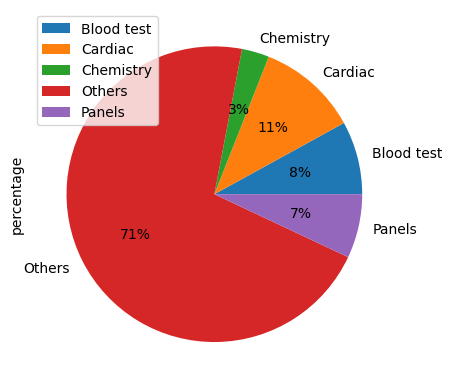

In [63]:
top_prcd_plot_pie_chart = top_prcd_pie_chart_df.plot.pie(y='percentage', autopct='%1.0f%%')

## Analysis #1. Find market share of each top procedure category on a yearly level

### 1) Find the total number of distinct claims from prepared dataset by year for each top category

In [64]:
total_num_uniq_cardiac_clm_by_year_df = cardiac_uniq_df.groupby('claim_year').agg(
    cardiac_clm_count=('claim_id', 'nunique')
)
total_num_uniq_cardiac_clm_by_year_df

,cardiac_clm_count
claim_year,
2016,3429
2017,3893
2018,4653


In [65]:
total_num_uniq_blood_test_clm_by_year_df = blood_test_uniq_df.groupby('claim_year').agg(
    blood_test_clm_count=('claim_id', 'nunique')
)
total_num_uniq_blood_test_clm_by_year_df

,blood_test_clm_count
claim_year,
2016,2414
2017,2738
2018,2986


In [66]:
total_num_uniq_panels_clm_by_year_df = panels_uniq_df.groupby('claim_year').agg(
    panels_clm_count=('claim_id', 'nunique')
)
total_num_uniq_panels_clm_by_year_df

,panels_clm_count
claim_year,
2016,2235
2017,2524
2018,2732


In [67]:
total_num_uniq_chemistry_clm_by_year_df = chemistry_uniq_df.groupby('claim_year').agg(
    chemistry_clm_count=('claim_id', 'nunique')
)
total_num_uniq_chemistry_clm_by_year_df

,chemistry_clm_count
claim_year,
2016,1014
2017,1155
2018,1271


### 2) Find total claim count by year

In [68]:
total_num_uniq_clm_by_year_df = medicare_df.groupby('claim_year').agg(
    total_clm_count=('claim_id', 'nunique')
)
total_num_uniq_clm_by_year_df

,total_clm_count
claim_year,
2014,1
2015,4
2016,28652
2017,32021
2018,37292


### 3) Combine all counts into one DF

In [69]:
clm_count_by_year_cat_df = total_num_uniq_cardiac_clm_by_year_df.join(
    total_num_uniq_blood_test_clm_by_year_df
).join(
    total_num_uniq_panels_clm_by_year_df
).join(
    total_num_uniq_chemistry_clm_by_year_df
).join(
    total_num_uniq_clm_by_year_df
)
clm_count_by_year_cat_df

,cardiac_clm_count,blood_test_clm_count,panels_clm_count,chemistry_clm_count,total_clm_count
claim_year,,,,,
2016,3429,2414,2235,1014,28652
2017,3893,2738,2524,1155,32021
2018,4653,2986,2732,1271,37292


### 4) Get number of all other claims besides the top 4 categories per year

In [70]:
clm_count_by_year_cat_df['other_clm_count'] = clm_count_by_year_cat_df['total_clm_count']\
    -clm_count_by_year_cat_df['cardiac_clm_count']\
    -clm_count_by_year_cat_df['blood_test_clm_count']\
    -clm_count_by_year_cat_df['panels_clm_count']\
    -clm_count_by_year_cat_df['chemistry_clm_count']
clm_count_by_year_cat_df

,cardiac_clm_count,blood_test_clm_count,panels_clm_count,chemistry_clm_count,total_clm_count,other_clm_count
claim_year,,,,,,
2016,3429,2414,2235,1014,28652,19560
2017,3893,2738,2524,1155,32021,21711
2018,4653,2986,2732,1271,37292,25650


### 5) Get percentage of claims for each category including others

In [71]:
clm_count_by_year_cat_perc_df = clm_count_by_year_cat_df
clm_count_by_year_cat_perc_df['cardiac_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['cardiac_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)
clm_count_by_year_cat_perc_df['blood_test_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['blood_test_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)
clm_count_by_year_cat_perc_df['panels_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['panels_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)
clm_count_by_year_cat_perc_df['chemistry_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['chemistry_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)
clm_count_by_year_cat_perc_df['other_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['other_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)

clm_count_by_year_cat_perc_df = clm_count_by_year_cat_perc_df.rename(
    columns={
        'cardiac_clm_perc': 'cardiac',
        'blood_test_clm_perc': 'blood_test',
        'panels_clm_perc': 'panels',
        'chemistry_clm_perc': 'chemistry',
        'other_clm_perc': 'other'
    }
)[[
    'cardiac','blood_test','panels','chemistry','other'
]]

clm_count_by_year_cat_perc_df

,cardiac,blood_test,panels,chemistry,other
claim_year,,,,,
2016,12,8,8,4,68
2017,12,9,8,4,68
2018,12,8,7,3,69


### 6) Create a 100% stacked bar graph

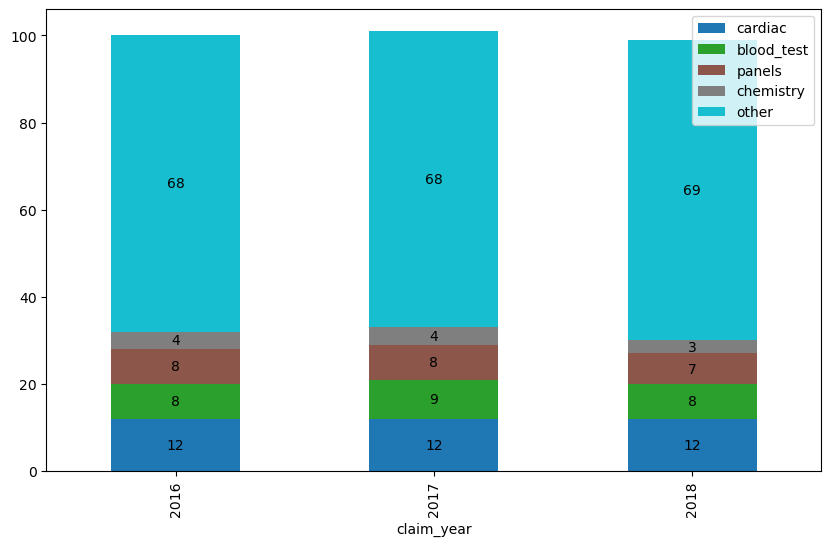

In [72]:
clm_count_by_year_cat_perc_100_stacked_bar_graph = clm_count_by_year_cat_perc_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in clm_count_by_year_cat_perc_100_stacked_bar_graph.containers:
    clm_count_by_year_cat_perc_100_stacked_bar_graph.bar_label(container, label_type='center')

### Business insights:
- The top four HCPCS/CPT categories still account for less than 50% of the entire market, so it would be more meaningful to analyze each category individually rather than looking at all the possible categories as a whole
- The share of each category remains consistent within the three-year period, which can indicate a stable demand for treatment. This also indicates keeping the sales force stable over the three years observed. The business leaders should keep the sales force stable in the future based on this observation.
- This can be supplemented with Rx data to determine whether there are any opportunities for expanding the market share for a specific pharmaceutical product at the cost of its competitions

## Analysis #2. Find the dollar distribution of each top procedure category on a yearly level

### 1) Find the average cost of cardiac claims per year for each top category

In [73]:
sum_cardiac_clm_cost_by_year_df = cardiac_uniq_df.drop_duplicates(
    'claim_id'
).groupby('claim_year').agg(
    {'claim_cost': 'sum'}
)

avg_cardiac_clm_cost_by_year_df = pd.merge(
    sum_cardiac_clm_cost_by_year_df,
    total_num_uniq_cardiac_clm_by_year_df,
    on='claim_year', how='inner'
).reset_index()

avg_cardiac_clm_cost_by_year_df['avg_clm_payment'] = round(
    avg_cardiac_clm_cost_by_year_df['claim_cost']/avg_cardiac_clm_cost_by_year_df['cardiac_clm_count'], 2
)
avg_cardiac_clm_cost_by_year_df['category'] = 'Cardiac'
avg_cardiac_clm_cost_by_year_df

,claim_year,claim_cost,cardiac_clm_count,avg_clm_payment,category
0,2016,259324.90,3429,75.63,Cardiac
1,2017,390198.42,3893,100.23,Cardiac
2,2018,610893.95,4653,131.29,Cardiac


In [74]:
sum_blood_test_clm_cost_by_year_df = blood_test_uniq_df.drop_duplicates(
    'claim_id'
).groupby('claim_year').agg(
    {'claim_cost': 'sum'}
)

avg_blood_test_clm_cost_by_year_df = pd.merge(
    sum_blood_test_clm_cost_by_year_df,
    total_num_uniq_blood_test_clm_by_year_df,
    on='claim_year', how='inner'
).reset_index()

avg_blood_test_clm_cost_by_year_df['avg_clm_payment'] = round(
    avg_blood_test_clm_cost_by_year_df['claim_cost']/avg_blood_test_clm_cost_by_year_df['blood_test_clm_count'], 2
)
avg_blood_test_clm_cost_by_year_df['category'] = 'Blood test'
avg_blood_test_clm_cost_by_year_df

,claim_year,claim_cost,blood_test_clm_count,avg_clm_payment,category
0,2016,227841.74,2414,94.38,Blood test
1,2017,314412.33,2738,114.83,Blood test
2,2018,392973.18,2986,131.61,Blood test


In [75]:
sum_panels_clm_cost_by_year_df = panels_uniq_df.drop_duplicates(
    'claim_id'
).groupby('claim_year').agg(
    {'claim_cost': 'sum'}
)

avg_panels_clm_cost_by_year_df = pd.merge(
    sum_panels_clm_cost_by_year_df,
    total_num_uniq_panels_clm_by_year_df,
    on='claim_year', how='inner'
).reset_index()

avg_panels_clm_cost_by_year_df['avg_clm_payment'] = round(
    avg_panels_clm_cost_by_year_df['claim_cost']/avg_panels_clm_cost_by_year_df['panels_clm_count'], 2
)
avg_panels_clm_cost_by_year_df['category'] = 'Panels'
avg_panels_clm_cost_by_year_df

,claim_year,claim_cost,panels_clm_count,avg_clm_payment,category
0,2016,221132.06,2235,98.94,Panels
1,2017,250382.29,2524,99.20,Panels
2,2018,464900.58,2732,170.17,Panels


In [76]:
sum_chemistry_clm_cost_by_year_df = chemistry_uniq_df.drop_duplicates(
    'claim_id'
).groupby('claim_year').agg(
    {'claim_cost': 'sum'}
)

avg_chemistry_clm_cost_by_year_df = pd.merge(
    sum_chemistry_clm_cost_by_year_df,
    total_num_uniq_chemistry_clm_by_year_df,
    on='claim_year', how='inner'
).reset_index()

avg_chemistry_clm_cost_by_year_df['avg_clm_payment'] = round(
    avg_chemistry_clm_cost_by_year_df['claim_cost']/avg_chemistry_clm_cost_by_year_df['chemistry_clm_count'], 2
)
avg_chemistry_clm_cost_by_year_df['category'] = 'Chemistry'
avg_chemistry_clm_cost_by_year_df

,claim_year,claim_cost,chemistry_clm_count,avg_clm_payment,category
0,2016,110144.05,1014,108.62,Chemistry
1,2017,169615.94,1155,146.85,Chemistry
2,2018,251120.68,1271,197.58,Chemistry


### 2) Combine all average cost into one DF

In [77]:
avg_clm_cost_df = pd.merge(
    pd.merge(
        pd.merge(
            avg_cardiac_clm_cost_by_year_df.rename(
                columns={'avg_clm_payment': 'Cardiac'}
            )[['claim_year','Cardiac']],
            avg_blood_test_clm_cost_by_year_df.rename(
                columns={'avg_clm_payment': 'Blood test'}
            )[['claim_year','Blood test']],
            on='claim_year', how='inner'
        ),
        avg_panels_clm_cost_by_year_df.rename(
            columns={'avg_clm_payment': 'Panels'}
        )[['claim_year','Panels']],
        on='claim_year', how='inner'
    ),
    avg_chemistry_clm_cost_by_year_df.rename(
       columns={'avg_clm_payment': 'Chemistry'}
    )[['claim_year','Chemistry']],
    on='claim_year', how='inner'
).set_index('claim_year')

avg_clm_cost_df

,Cardiac,Blood test,Panels,Chemistry
claim_year,,,,
2016,75.63,94.38,98.94,108.62
2017,100.23,114.83,99.20,146.85
2018,131.29,131.61,170.17,197.58


### 3) Create a line graph

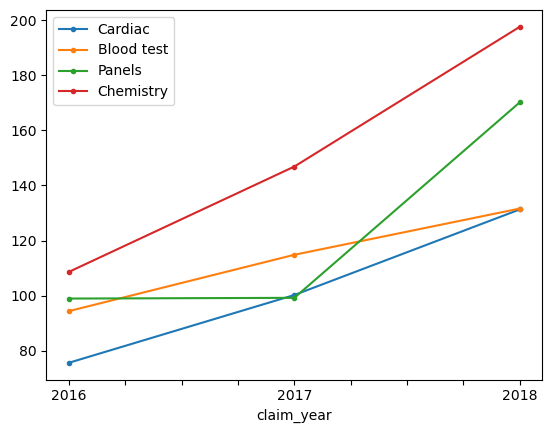

In [78]:
avg_clm_cost_graph = avg_clm_cost_df.plot(kind='line', style='.-')

### Business insights:
- Cost continues to increase over the years for all categories 
- While cardiac procedures are cost efficient relatively, cost is still increasing and patients may face barriers for treatment and will need more attention to payer/plan-related solutions

## Analysis #3. Find the trend for providers performing top procedures

### 1) Count the number of cardiac claims per year and provider (NPI)

In [79]:
num_cardiac_clm_by_yr_npi_df = cardiac_uniq_df.groupby(
    ['claim_year', 'npi_id']
).agg({'claim_id': 'count'}).reset_index()
num_cardiac_clm_by_yr_npi_df.sort_values('claim_id', ascending=False)

,claim_year,npi_id,claim_id
6631,2018,1.538145e+09,138
6886,2018,1.619913e+09,97
3756,2017,1.538145e+09,84
5180,2018,1.063497e+09,73
3983,2017,1.619913e+09,68
...,...,...,...
2786,2017,1.184621e+09,1
2785,2017,1.184621e+09,1
2783,2017,1.184612e+09,1
2781,2017,1.184611e+09,1


### 2) Categorize the number of claims into different buckets: 1, 2-4, 5-9, 10-19, 20+

In [80]:
cardiac_conditions = [
    (num_cardiac_clm_by_yr_npi_df['claim_id'] == 1),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 2) & (num_cardiac_clm_by_yr_npi_df['claim_id'] < 5),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 5) & (num_cardiac_clm_by_yr_npi_df['claim_id'] < 10),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 10) & (num_cardiac_clm_by_yr_npi_df['claim_id'] < 20),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_cardiac_clm_by_yr_npi_df['bucket'] = np.select(cardiac_conditions, letters)
num_cardiac_clm_by_yr_npi_df

,claim_year,npi_id,claim_id,bucket
0,2016,1.003285e+09,1,1
1,2016,1.003802e+09,1,1
2,2016,1.003803e+09,1,1
3,2016,1.003803e+09,1,1
4,2016,1.003808e+09,1,1
...,...,...,...,...
7990,2018,1.992920e+09,1,1
7991,2018,1.992942e+09,1,1
7992,2018,1.992952e+09,1,1
7993,2018,1.992978e+09,1,1


### 3) Find the number of providers (NPI) per year and bucket, and pivot to have the buckets as columns and the number of providers as values

In [81]:
cardiac_clm_group_by_yr_npi_df = num_cardiac_clm_by_yr_npi_df.groupby(
    ['bucket', 'claim_year']
).agg({'npi_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])
cardiac_clm_group_by_yr_npi_df

,bucket,claim_year,npi_id
0,1,2016,2122
1,1,2017,2390
2,1,2018,2725
3,10-19,2016,21
4,10-19,2017,16
5,10-19,2018,23
6,2-4,2016,149
7,2-4,2017,202
8,2-4,2018,225
9,20+,2016,16


In [82]:
cardiac_clm_group_by_yr_npi_df = cardiac_clm_group_by_yr_npi_df.pivot(
    index='claim_year', columns='bucket', values='npi_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]
cardiac_clm_group_by_yr_npi_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,2122,149,23,21,16
2017,2390,202,26,16,17
2018,2725,225,18,23,22


### 4) Create a stacked bar graph

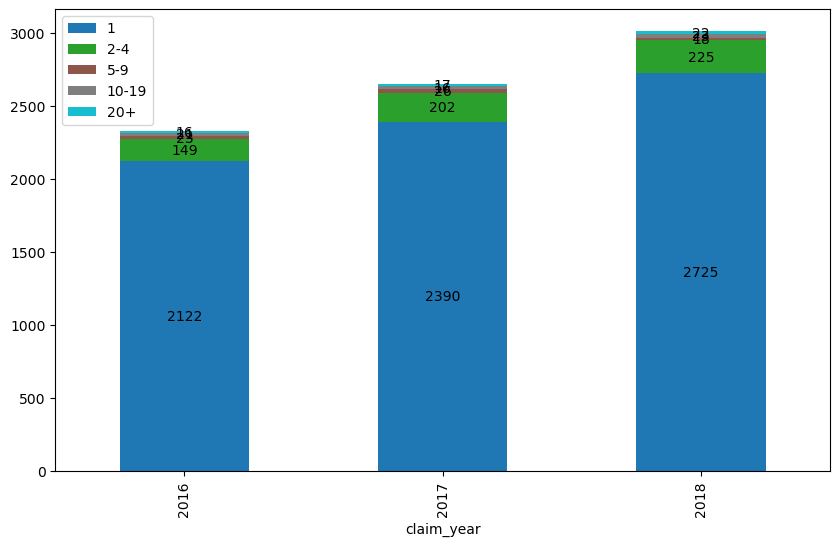

In [83]:
cardiac_clm_group_by_yr_npi_stacked_bar_graph = cardiac_clm_group_by_yr_npi_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in cardiac_clm_group_by_yr_npi_stacked_bar_graph.containers:
    cardiac_clm_group_by_yr_npi_stacked_bar_graph.bar_label(container, label_type='center')

### 5) Repeat 1) - 4) for all other top procedure categories

In [84]:
num_blood_test_clm_by_yr_npi_df = blood_test_uniq_df.groupby(
    ['claim_year', 'npi_id']
).agg({'claim_id': 'count'}).reset_index()

blood_test_conditions = [
    (num_blood_test_clm_by_yr_npi_df['claim_id'] == 1),
    (num_blood_test_clm_by_yr_npi_df['claim_id'] >= 2) & (num_blood_test_clm_by_yr_npi_df['claim_id'] < 5),
    (num_blood_test_clm_by_yr_npi_df['claim_id'] >= 5) & (num_blood_test_clm_by_yr_npi_df['claim_id'] < 10),
    (num_blood_test_clm_by_yr_npi_df['claim_id'] >= 10) & (num_blood_test_clm_by_yr_npi_df['claim_id'] < 20),
    (num_blood_test_clm_by_yr_npi_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_blood_test_clm_by_yr_npi_df['bucket'] = np.select(blood_test_conditions, letters)

blood_test_clm_group_by_yr_npi_df = num_blood_test_clm_by_yr_npi_df.groupby(
    ['bucket', 'claim_year']
).agg({'npi_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

blood_test_clm_group_by_yr_npi_df = blood_test_clm_group_by_yr_npi_df.pivot(
    index='claim_year', columns='bucket', values='npi_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

blood_test_clm_group_by_yr_npi_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,892,68,29,23,21
2017,872,100,25,22,27
2018,912,80,26,17,32


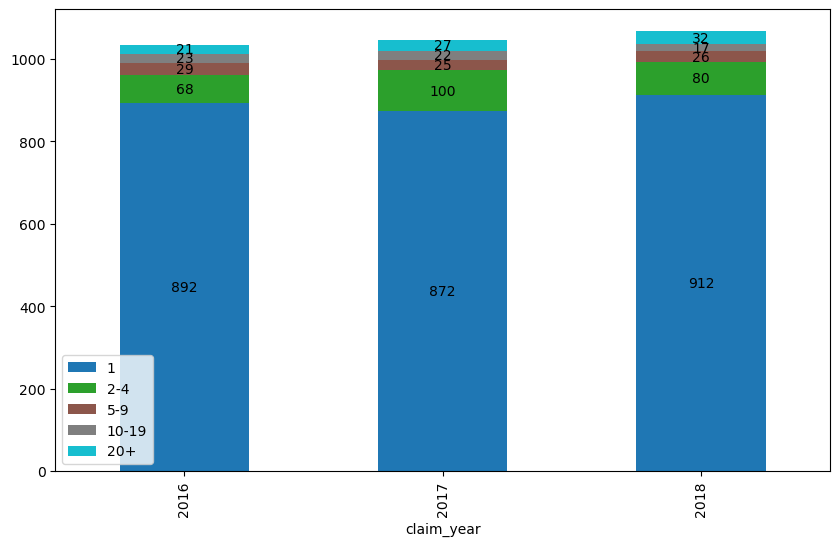

In [85]:
blood_test_clm_group_by_yr_npi_stacked_bar_graph = blood_test_clm_group_by_yr_npi_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in blood_test_clm_group_by_yr_npi_stacked_bar_graph.containers:
    blood_test_clm_group_by_yr_npi_stacked_bar_graph.bar_label(container, label_type='center')

In [86]:
num_panels_clm_by_yr_npi_df = panels_uniq_df.groupby(
    ['claim_year', 'npi_id']
).agg({'claim_id': 'count'}).reset_index()

panels_conditions = [
    (num_panels_clm_by_yr_npi_df['claim_id'] == 1),
    (num_panels_clm_by_yr_npi_df['claim_id'] >= 2) & (num_panels_clm_by_yr_npi_df['claim_id'] < 5),
    (num_panels_clm_by_yr_npi_df['claim_id'] >= 5) & (num_panels_clm_by_yr_npi_df['claim_id'] < 10),
    (num_panels_clm_by_yr_npi_df['claim_id'] >= 10) & (num_panels_clm_by_yr_npi_df['claim_id'] < 20),
    (num_panels_clm_by_yr_npi_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_panels_clm_by_yr_npi_df['bucket'] = np.select(panels_conditions, letters)

panels_clm_group_by_yr_npi_df = num_panels_clm_by_yr_npi_df.groupby(
    ['bucket', 'claim_year']
).agg({'npi_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

panels_clm_group_by_yr_npi_df = panels_clm_group_by_yr_npi_df.pivot(
    index='claim_year', columns='bucket', values='npi_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

panels_clm_group_by_yr_npi_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,806,93,22,24,19
2017,818,88,29,18,24
2018,826,71,31,20,27


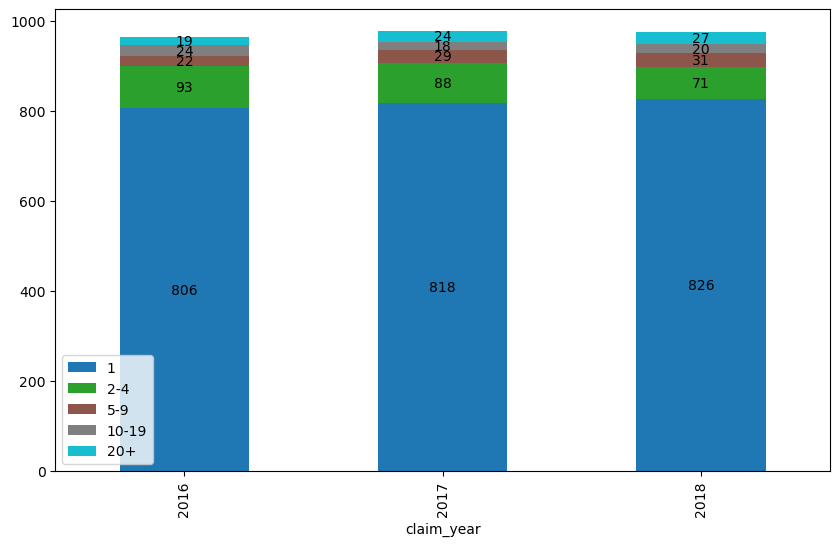

In [87]:
panels_clm_group_by_yr_npi_stacked_bar_graph = panels_clm_group_by_yr_npi_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in panels_clm_group_by_yr_npi_stacked_bar_graph.containers:
    panels_clm_group_by_yr_npi_stacked_bar_graph.bar_label(container, label_type='center')

In [88]:
num_chemistry_clm_by_yr_npi_df = chemistry_uniq_df.groupby(
    ['claim_year', 'npi_id']
).agg({'claim_id': 'count'}).reset_index()

chemistry_conditions = [
    (num_chemistry_clm_by_yr_npi_df['claim_id'] == 1),
    (num_chemistry_clm_by_yr_npi_df['claim_id'] >= 2) & (num_chemistry_clm_by_yr_npi_df['claim_id'] < 5),
    (num_chemistry_clm_by_yr_npi_df['claim_id'] >= 5) & (num_chemistry_clm_by_yr_npi_df['claim_id'] < 10),
    (num_chemistry_clm_by_yr_npi_df['claim_id'] >= 10) & (num_chemistry_clm_by_yr_npi_df['claim_id'] < 20),
    (num_chemistry_clm_by_yr_npi_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_chemistry_clm_by_yr_npi_df['bucket'] = np.select(chemistry_conditions, letters)

chemistry_clm_group_by_yr_npi_df = num_chemistry_clm_by_yr_npi_df.groupby(
    ['bucket', 'claim_year']
).agg({'npi_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

chemistry_clm_group_by_yr_npi_df = chemistry_clm_group_by_yr_npi_df.pivot(
    index='claim_year', columns='bucket', values='npi_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

chemistry_clm_group_by_yr_npi_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,397,49,18,13,7
2017,404,52,19,16,10
2018,422,56,18,14,13


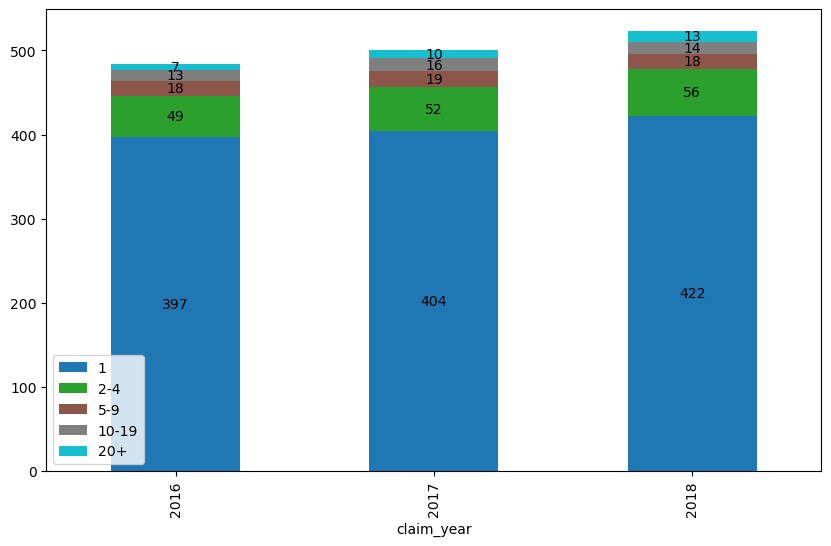

In [89]:
chemistry_clm_group_by_yr_npi_stacked_bar_graph = chemistry_clm_group_by_yr_npi_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in chemistry_clm_group_by_yr_npi_stacked_bar_graph.containers:
    chemistry_clm_group_by_yr_npi_stacked_bar_graph.bar_label(container, label_type='center')

### Business insights:
- For each top category, particularly cardiac, the majority of the providers/HCPs had 1 claim associated with them, indicating a significant expansion opportunity. By supplementing this insight with Rx data, the sales team can create a plan that would involve in-person promotions to take advantage of the expansion opportunity for this group of providers/HCPs
- For the providers/HCPs with more than 1 claim associated with them, we can ring-fence them by coordinating in-person and non-personal promotions, assuming Rx data is available

## Analysis #4. Find the trend for patients receiving top procedures

### Perform similar exercise as Analysis #3, replacing providers with patients (bene_mbi_id)

In [90]:
num_cardiac_clm_by_yr_pnt_df = cardiac_uniq_df.groupby(
    ['claim_year', 'patient_id']
).agg({'claim_id': 'count'}).reset_index()

cardiac_conditions = [
    (num_cardiac_clm_by_yr_pnt_df['claim_id'] == 1),
    (num_cardiac_clm_by_yr_pnt_df['claim_id'] >= 2) & (num_cardiac_clm_by_yr_pnt_df['claim_id'] < 5),
    (num_cardiac_clm_by_yr_pnt_df['claim_id'] >= 5) & (num_cardiac_clm_by_yr_pnt_df['claim_id'] < 10),
    (num_cardiac_clm_by_yr_pnt_df['claim_id'] >= 10) & (num_cardiac_clm_by_yr_pnt_df['claim_id'] < 20),
    (num_cardiac_clm_by_yr_pnt_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_cardiac_clm_by_yr_pnt_df['bucket'] = np.select(cardiac_conditions, letters)

cardiac_clm_group_by_yr_pnt_df = num_cardiac_clm_by_yr_pnt_df.groupby(
    ['bucket', 'claim_year']
).agg({'patient_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

cardiac_clm_group_by_yr_pnt_df = cardiac_clm_group_by_yr_pnt_df.pivot(
    index='claim_year', columns='bucket', values='patient_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

cardiac_clm_group_by_yr_pnt_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,136,290,195,85,8
2017,118,310,234,88,9
2018,114,281,244,115,24


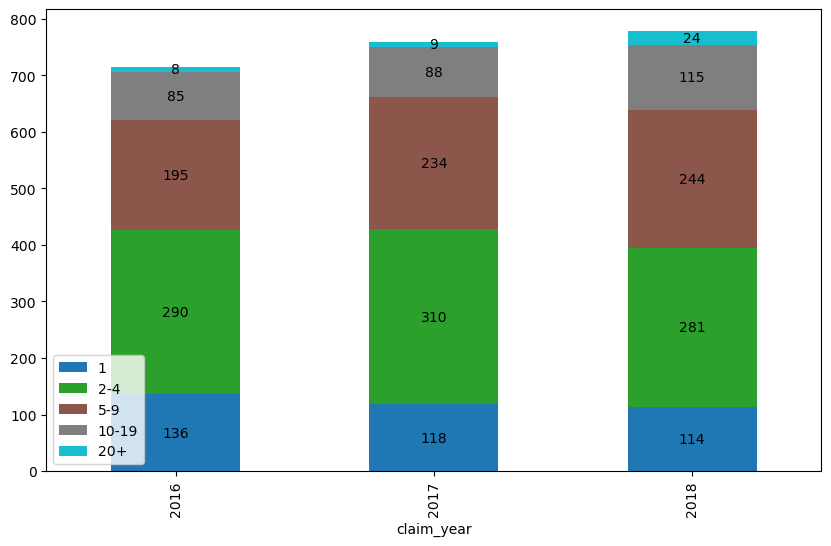

In [91]:
cardiac_clm_group_by_yr_pnt_stacked_bar_graph = cardiac_clm_group_by_yr_pnt_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in cardiac_clm_group_by_yr_pnt_stacked_bar_graph.containers:
    cardiac_clm_group_by_yr_pnt_stacked_bar_graph.bar_label(container, label_type='center')

In [92]:
num_blood_test_clm_by_yr_pnt_df = blood_test_uniq_df.groupby(
    ['claim_year', 'patient_id']
).agg({'claim_id': 'count'}).reset_index()

blood_test_conditions = [
    (num_blood_test_clm_by_yr_pnt_df['claim_id'] == 1),
    (num_blood_test_clm_by_yr_pnt_df['claim_id'] >= 2) & (num_blood_test_clm_by_yr_pnt_df['claim_id'] < 5),
    (num_blood_test_clm_by_yr_pnt_df['claim_id'] >= 5) & (num_blood_test_clm_by_yr_pnt_df['claim_id'] < 10),
    (num_blood_test_clm_by_yr_pnt_df['claim_id'] >= 10) & (num_blood_test_clm_by_yr_pnt_df['claim_id'] < 20),
    (num_blood_test_clm_by_yr_pnt_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_blood_test_clm_by_yr_pnt_df['bucket'] = np.select(blood_test_conditions, letters)

blood_test_clm_group_by_yr_pnt_df = num_blood_test_clm_by_yr_pnt_df.groupby(
    ['bucket', 'claim_year']
).agg({'patient_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

blood_test_clm_group_by_yr_pnt_df = blood_test_clm_group_by_yr_pnt_df.pivot(
    index='claim_year', columns='bucket', values='patient_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

blood_test_clm_group_by_yr_pnt_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,163.0,318.0,144.0,33.0,2.0
2017,137.0,353.0,166.0,42.0,2.0
2018,158.0,331.0,186.0,54.0,NaN


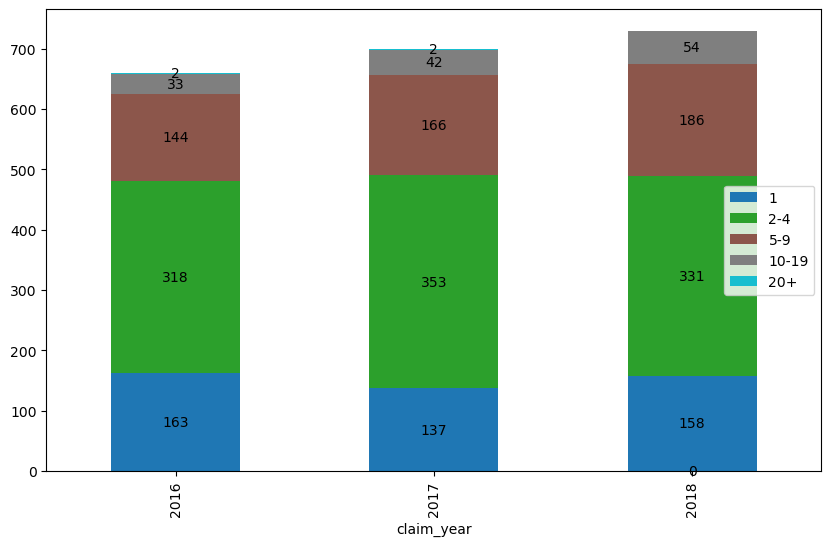

In [93]:
blood_test_clm_group_by_yr_pnt_stacked_bar_graph = blood_test_clm_group_by_yr_pnt_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in blood_test_clm_group_by_yr_pnt_stacked_bar_graph.containers:
    blood_test_clm_group_by_yr_pnt_stacked_bar_graph.bar_label(container, label_type='center')

In [94]:
num_panels_clm_by_yr_pnt_df = panels_uniq_df.groupby(
    ['claim_year', 'patient_id']
).agg({'claim_id': 'count'}).reset_index()

panels_conditions = [
    (num_panels_clm_by_yr_pnt_df['claim_id'] == 1),
    (num_panels_clm_by_yr_pnt_df['claim_id'] >= 2) & (num_panels_clm_by_yr_pnt_df['claim_id'] < 5),
    (num_panels_clm_by_yr_pnt_df['claim_id'] >= 5) & (num_panels_clm_by_yr_pnt_df['claim_id'] < 10),
    (num_panels_clm_by_yr_pnt_df['claim_id'] >= 10) & (num_panels_clm_by_yr_pnt_df['claim_id'] < 20),
    (num_panels_clm_by_yr_pnt_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_panels_clm_by_yr_pnt_df['bucket'] = np.select(panels_conditions, letters)

panels_clm_group_by_yr_pnt_df = num_panels_clm_by_yr_pnt_df.groupby(
    ['bucket', 'claim_year']
).agg({'patient_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

panels_clm_group_by_yr_pnt_df = panels_clm_group_by_yr_pnt_df.pivot(
    index='claim_year', columns='bucket', values='patient_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19', '20+']]

panels_clm_group_by_yr_pnt_df

,1,2-4,5-9,10-19,20+
claim_year,,,,,
2016,152.0,341.0,143.0,18.0,1.0
2017,147.0,374.0,175.0,22.0,NaN
2018,143.0,372.0,194.0,25.0,1.0


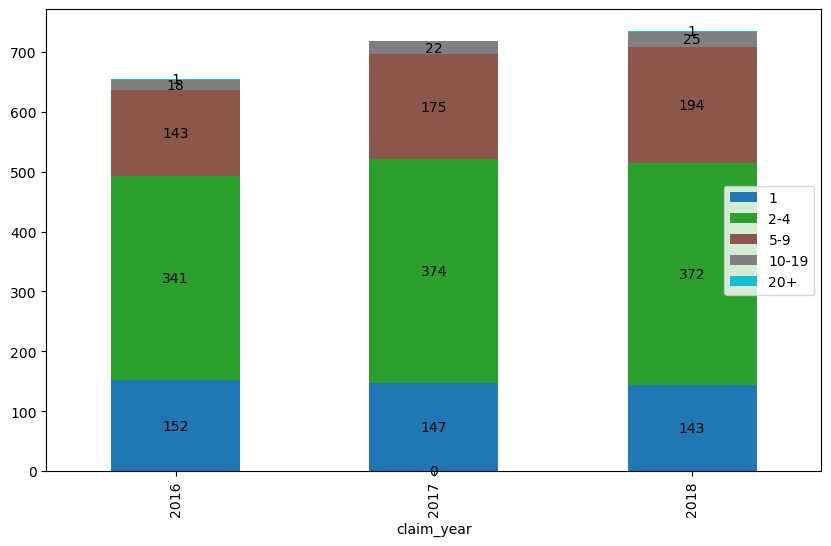

In [95]:
panels_clm_group_by_yr_pnt_stacked_bar_graph = panels_clm_group_by_yr_pnt_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in panels_clm_group_by_yr_pnt_stacked_bar_graph.containers:
    panels_clm_group_by_yr_pnt_stacked_bar_graph.bar_label(container, label_type='center')

In [96]:
num_chemistry_clm_by_yr_pnt_df = chemistry_uniq_df.groupby(
    ['claim_year', 'patient_id']
).agg({'claim_id': 'count'}).reset_index()

chemistry_conditions = [
    (num_chemistry_clm_by_yr_pnt_df['claim_id'] == 1),
    (num_chemistry_clm_by_yr_pnt_df['claim_id'] >= 2) & (num_chemistry_clm_by_yr_pnt_df['claim_id'] < 5),
    (num_chemistry_clm_by_yr_pnt_df['claim_id'] >= 5) & (num_chemistry_clm_by_yr_pnt_df['claim_id'] < 10),
    (num_chemistry_clm_by_yr_pnt_df['claim_id'] >= 10) & (num_chemistry_clm_by_yr_pnt_df['claim_id'] < 20),
    (num_chemistry_clm_by_yr_pnt_df['claim_id'] >= 20)
]

letters = ['1', '2-4', '5-9', '10-19', '20+']

num_chemistry_clm_by_yr_pnt_df['bucket'] = np.select(chemistry_conditions, letters)

chemistry_clm_group_by_yr_pnt_df = num_chemistry_clm_by_yr_pnt_df.groupby(
    ['bucket', 'claim_year']
).agg({'patient_id': 'count'}).reset_index().sort_values(['bucket','claim_year'])

chemistry_clm_group_by_yr_pnt_df = chemistry_clm_group_by_yr_pnt_df.pivot(
    index='claim_year', columns='bucket', values='patient_id'
).reset_index().rename_axis(None, axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10-19']]#, '20+']]

chemistry_clm_group_by_yr_pnt_df

,1,2-4,5-9,10-19
claim_year,,,,
2016,225.0,229.0,34.0,NaN
2017,255.0,254.0,33.0,5.0
2018,248.0,255.0,50.0,4.0


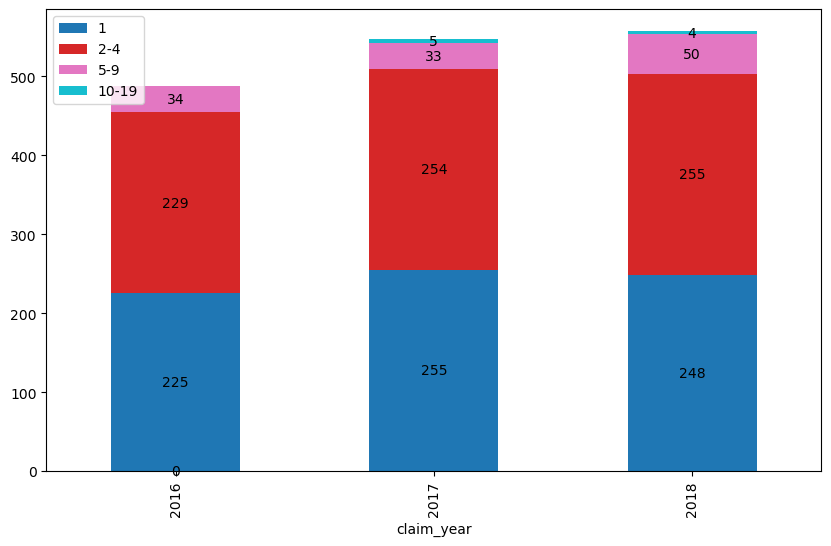

In [97]:
chemistry_clm_group_by_yr_pnt_stacked_bar_graph = chemistry_clm_group_by_yr_pnt_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in chemistry_clm_group_by_yr_pnt_stacked_bar_graph.containers:
    chemistry_clm_group_by_yr_pnt_stacked_bar_graph.bar_label(container, label_type='center')

### Business insights:
- The majority of the patients received multiple cardiac procedures over the given time period
- Rx data can utilized here to further understand the relationship between the HCPs and patients. Patient adherence and persistence for therapies can be leveraged to fine-tune HCP messaging to complement the sales plan.
- We can make deep-dives by combining patient demographics (age, gender, geography, etc.) to further understand patient behavior  and plan specific investment strategies around HCPs and patients